# Optimal Control of Covid-19 Spread
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

## Problem Statement and Model 
---------------------------------------------------------------------------------------------------
We wish to determine optimal social distancing policy to control spread of Covid-19 and minimize the economic impact of doing so. We'll model the spread of the virus through a given population using the SEIR Model which considers 4 population subsets that follow:
$$\text{Susceptible} \rightarrow \text{Exposed} \rightarrow \text{Infectious} \rightarrow \text{Recovered}$$
This model is formalized as:
$$
\begin{gather*}
\frac{ds(t)}{dt} = (u(t) - 1)\beta si(t) \\
\frac{de(t)}{dt} = (1 - u(t))\beta si(t) - \xi e(t) \\
\frac{di(t)}{dt} = \xi e(t) - \gamma i(t)\\
\frac{dr(t)}{dt} = \gamma i(t) \\
si(t) = s(t) i(t)
\end{gather*}
$$
where $s(t)$ is the susceptible population, $e(t)$ is the exposed population, $i(t)$ is the infectious population, $r(t)$ is the recovered population, and $u(t) \in [0, 1]$ is the enforced population isolation (social distancing). The other values denote model parameters that will be specific to the contagion in question. 

For our case study, we'll consider the incubation constant $\xi$ to be an uncertain parameter $\xi \sim \mathcal{U}(\underline{\xi}, \overline{\xi})$. This introduces to infinite dependencies into our model: time $t$ and uncertain incubation $\xi$. Moreover we'll seek to minimize the isolation measures $u(t)$ that are implemented while limiting the amount of infected individuals $i(t)$ to be below a threshold $i_{max}$ to a certain tolerance $\epsilon$. Thus, the optimization problem becomes:
$$
\begin{aligned}
&&\min_{} &&& \int_{t \in \mathcal{D}_{t}} u(t) dt \\
&& \text{s.t.} &&& \frac{\partial s(t, \xi)}{\partial t} = (u(t) - 1)\beta si(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&&&& \frac{\partial e(t, \xi)}{\partial t} = (1 - u(t))\beta si(t, \xi) - \xi e(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&&&& \frac{\partial i(t, \xi)}{\partial t} = \xi e(t, \xi) - \gamma i(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&&&& \frac{\partial r(t, \xi)}{\partial t} = \gamma i(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&&&& si(t, \xi) = s(t, \xi) i(t, \xi), && \forall \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&&&& s(0, \xi) = s_0, e(0, \xi) = e_0, i(0, \xi) = i_0, r(0, \xi) = r_0, && \forall \xi \in \mathcal{D}_{\xi} \\
&&&&& \mathbb{E}_{t}\left[i(t, \xi) - i_{max} \right]_+ \leq \epsilon, && \forall \xi \in \mathcal{D}_{\xi} \\
&&&&& u(t) \in [0, 0.8] \\
&&&&& \xi \sim \mathcal{U}(\underline{\xi}, \overline{\xi})
\end{aligned}
$$
Notice that the SEIR model variables now all depend on both $t$ and $\xi$, except $u(t)$ which means we need to decide our policy before knowing the true value of $\xi$. We also enforce a fairly exotic constraint $$\mathbb{E}_{t}\left[i(t, \xi) - i_{max} \right]_+ \leq \epsilon$$ that enforces the acceptable threshold of infected individuals to a certain tolerance over time as explained above. 

## Modeling in InfiniteOpt 
---------------------------------------------------------------------------------------------------
Traditional modeling frameworks like JuMP cannot be used to solve this model directly because it is infinite, contains partial difference equations, and contains a time expectation. We would first have to transform it into a transcripted (discretized) variant by applying all the necessary techniques (e.g., orthogonal collocation over finite elements, trapezoid rule, etc.) which is very combersome and nontrivial in this case. 

However, we can directly model the above form in InfiniteOpt and it will take care of the rest! Let's get started by importing the needed packages and specifying the model parameters that we'll need.

In [40]:
using JuMP, InfiniteOpt, Ipopt, Distributions, Plots

In [41]:
# Set the SEIR parameters
γ = 0.303
β = 0.727
N = 1e5
ξ_min = 0.1 
ξ_max = 0.6

# Set the domain information
i_max = 0.02
ϵ = 0.005
t0 = 0
tf = 200
extra_ts = [0.001, 0.002, 0.004, 0.008, 0.02, 0.04, 0.08, 0.2, 0.4, 0.8]
num_samples = 20

# Set the intial condition values
e0 = 1 / N
i0 = 0
r0 = 0
s0 = 1 - 1 / N;

## Model Initialization
---------------------------------------------------------------------------------------------------
Now let's setup our infinite model and select Ipopt as our optimizer that will be used to solve it. This is accomplished making an `InfiniteModel`.

In [42]:
model = InfiniteModel(Ipopt.Optimizer);

## Infinite Parameter Definition 
---------------------------------------------------------------------------------------------------
We now need to define the infinite parameters $t \in [t_0, t_f]$ and $\xi \sim \mathcal{U}(\underline{\xi}, \overline{\xi})$. This is accomplished with `@infinite_parameter`. We'll also include the following specifications:
* use 101 equidistant time points
* specify that orgothonal collocation using 2 nodes should be used for time derivatives
* specify that the number of random scenarios should equal `num_samples`
* add `extra_ts` as extra time points

In [43]:
@infinite_parameter(model, t ∈ [t0, tf], num_supports = 101, 
                    derivative_method = OrthogonalCollocation(2))
@infinite_parameter(model, ξ ∈ Uniform(ξ_min, ξ_max), num_supports = num_samples)
add_supports(t, extra_ts)

## Infinite Variable Definition 
---------------------------------------------------------------------------------------------------
With our infinite parameters defined, we can now define our infintie variables:
* $s(t, \xi) \geq 0$
* $e(t, \xi) \geq 0$
* $i(t, \xi) \geq 0$
* $r(t, \xi) \geq 0$
* $si(t, \xi)$
* $0 \leq u(t) \leq 0.8$

In [44]:
@infinite_variable(model, s(t, ξ) ≥ 0)
@infinite_variable(model, e(t, ξ) ≥ 0)
@infinite_variable(model, i(t, ξ) ≥ 0)
@infinite_variable(model, r(t, ξ) ≥ 0)
@infinite_variable(model, si(t, ξ))
@infinite_variable(model, 0 ≤ u(t) ≤ 0.8, start = 0.2)

u(t)

## Objective Definition 
---------------------------------------------------------------------------------------------------
Now its time to add the objective $\min \ \int_{t \in \mathcal{D}_{t}} u(t) dt$ using `@objective`.

In [45]:
@objective(model, Min, integral(u, t))

integral{t in [0, 200]}[u(t)]

## Constraint Definition
---------------------------------------------------------------------------------------------------
The last step now to defining our model is to define the constraints using `@constraint` and `@BDconstraint`. This will involve defining the initial conditions:
$$s(0, \xi) = s_0, e(0, \xi) = e_0, i(0, \xi) = i_0, r(0, \xi) = r_0, \ \forall \xi \in \mathcal{D}_{\xi},$$
the model equations:
$$
\begin{aligned}
&&& \frac{\partial s(t, \xi)}{\partial t} = (u(t) - 1)\beta si(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&& \frac{\partial e(t, \xi)}{\partial t} = (1 - u(t))\beta si(t, \xi) - \xi e(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&& \frac{\partial i(t, \xi)}{\partial t} = \xi e(t, \xi) - \gamma i(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&& \frac{\partial r(t, \xi)}{\partial t} = \gamma i(t, \xi), && \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi} \\
&&& si(t, \xi) = s(t, \xi) i(t, \xi), && \forall \forall t \in \mathcal{D}_{t}, \xi \in \mathcal{D}_{\xi}, \\
\end{aligned}
$$
and the expectation constraint:
$$\mathbb{E}_{t}\left[i(t, \xi) - i_{max} \right]_+ \leq \epsilon, \ \forall \xi \in \mathcal{D}_{\xi}.$$

Here the maximization in the final constraint can be dealt with by introducing a variable $y(t)$ and transforming it into:
$$
\begin{aligned}
&&& y(t) \geq 0, && \forall t \in \mathcal{D}_t \\
&&& i(t, \xi) - i_{max} \leq y(t), && \forall t \in \mathcal{D}_t, \xi \in \mathcal{D}_\xi \\
&&& \mathbb{E}_t\left[ y(t) \right] \leq \epsilon, && \forall \xi \in \mathcal{D}_\xi \\
\end{aligned}
$$

In [46]:
# Define the initial conditions
@BDconstraint(model, t == 0, s == s0)
@BDconstraint(model, t == 0, e == e0)
@BDconstraint(model, t == 0, i == i0)
@BDconstraint(model, t == 0, r == r0)

# Define the SEIR equations
@constraint(model, s_constr, deriv(s, t) == -(1 - u) * β * si)
@constraint(model, e_constr, deriv(e, t) == (1 - u) * β * si - ξ * e)
@constraint(model, i_constr, deriv(i, t) == ξ * e - γ * i)
@constraint(model, r_constr, deriv(r, t) == γ * i)
@constraint(model, si == s * i)

# Define the time expectation constraint
@infinite_variable(model, y(t) ≥ 0, start = 0)
@constraint(model, imax_constr, i - i_max ≤ y)
@constraint(model, exceed_cosntr, expect(y, t) ≤ ϵ)

exceed_cosntr : expect{t}[y(t)] <= 0.005

## Display the Infinite Model 
---------------------------------------------------------------------------------------------------
Let's display `model` now that it is fully defined.

In [47]:
print(model)

Min integral{t in [0, 200]}[u(t)]
Subject to
 s(t, ξ) >= 0.0, for all t in [0, 200], ξ ~ Uniform
 e(t, ξ) >= 0.0, for all t in [0, 200], ξ ~ Uniform
 i(t, ξ) >= 0.0, for all t in [0, 200], ξ ~ Uniform
 r(t, ξ) >= 0.0, for all t in [0, 200], ξ ~ Uniform
 u(t) >= 0.0, for all t in [0, 200]
 u(t) <= 0.8, for all t in [0, 200]
 s(t, ξ) == 0.99999, for all t == 0, ξ ~ Uniform
 e(t, ξ) == 1.0e-5, for all t == 0, ξ ~ Uniform
 i(t, ξ) == 0.0, for all t == 0, ξ ~ Uniform
 r(t, ξ) == 0.0, for all t == 0, ξ ~ Uniform
 s_constr : -0.727 si(t, ξ)*u(t) + d/dt[s(t, ξ)] + 0.727 si(t, ξ) == 0.0, for all t in [0, 200], ξ ~ Uniform
 e_constr : 0.727 si(t, ξ)*u(t) + ξ*e(t, ξ) + d/dt[e(t, ξ)] - 0.727 si(t, ξ) == 0.0, for all t in [0, 200], ξ ~ Uniform
 i_constr : -e(t, ξ)*ξ + d/dt[i(t, ξ)] + 0.303 i(t, ξ) == 0.0, for all t in [0, 200], ξ ~ Uniform
 r_constr : d/dt[r(t, ξ)] - 0.303 i(t, ξ) == 0.0, for all t in [0, 200], ξ ~ Uniform
 -i(t, ξ)*s(t, ξ) + si(t, ξ) == 0.0, for all t in [0, 200], ξ ~ Uniform
 y(t

## Optimize the Model
---------------------------------------------------------------------------------------------------
Let's solve our model and find the optimal policy. All we have to do is invoke `optimize!` and the model will automatically be transformed solved behind the scenes.

In [48]:
optimize!(model)

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    64220
Number of nonzeros in inequality constraint Jacobian.:     4551
Number of nonzeros in Lagrangian Hessian.............:     6660

Total number of variables............................:    20202
                     variables with only lower bounds:     8991
                variables with lower and upper bounds:      111
                     variables with only upper bounds:        0
Total number of equality constraints.................:    19980
Total number of inequality constraints...............:     2221
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     2221

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

## Retrieve and Plot the Results
---------------------------------------------------------------------------------------------------
Now we can retrieve the optimal results and plot them to visualize the optimal policy. Note that the values of infinite variables will be returned as arrays corresponding to how the supports were used to discretize our model. We can retrieve our values using `value`.

In [49]:
# Get results
r_opt = value(r, ndarray = true) * 100 # make the population fractions into percentages
s_opt = value(s, ndarray = true) * 100
i_opt = value(i, ndarray = true) * 100
e_opt = value(e, ndarray = true) * 100
u_opt = value(u)
obj_opt = objective_value(model)
ts = value(t)
ξs = value(ξ);

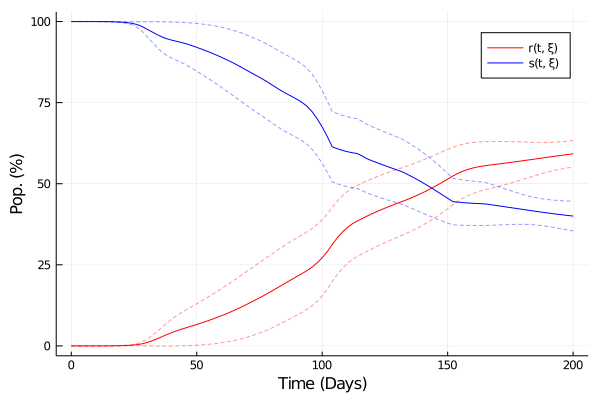

In [50]:
# Plot the values r(t, ξ) over time with confidence bounds
r_mean = mean(r_opt, dims = 2)
r_std = std(r_opt, dims = 2)
plot(ts, r_mean, label = "r(t, ξ)", linecolor = :red)
plot!(ts, r_mean + r_std, linecolor = :red, linestyle = :dash, linealpha = 0.4, label = "")
plot!(ts, r_mean - r_std, linecolor = :red, linestyle = :dash, linealpha = 0.4, label = "")

# Plot the values s(t, ξ) over time with confidence bounds
s_mean = mean(s_opt, dims = 2)
s_std = std(s_opt, dims = 2)
plot!(ts, s_mean, label = "s(t, ξ)", linecolor = :blue)
plot!(ts, s_mean + s_std, linecolor = :blue, linestyle = :dash, linealpha = 0.4, label = "")
plot!(ts, s_mean - s_std, linecolor = :blue, linestyle = :dash, linealpha = 0.4, label = "")
ylabel!("Pop. (%)")
xlabel!("Time (Days)")

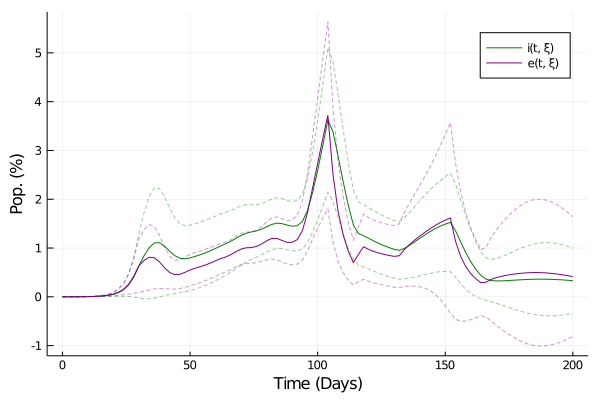

In [51]:
# Plot the values i(t, ξ) over time with confidence bounds
i_mean = mean(i_opt, dims = 2)
i_std = std(i_opt, dims = 2)
plot(ts, i_mean, label = "i(t, ξ)", linecolor = :green)
plot!(ts, i_mean + i_std, linecolor = :green, linestyle = :dash, linealpha = 0.4, label = "")
plot!(ts, i_mean - i_std, linecolor = :green, linestyle = :dash, linealpha = 0.4, label = "")

# Plot the values e(t, ξ) over time with confidence bounds
e_mean = mean(e_opt, dims = 2)
e_std = std(e_opt, dims = 2)
plot!(ts, e_mean, label = "e(t, ξ)", linecolor = :purple)
plot!(ts, e_mean + e_std, linecolor = :purple, linestyle = :dash, linealpha = 0.4, label = "")
plot!(ts, e_mean - e_std, linecolor = :purple, linestyle = :dash, linealpha = 0.4, label = "")
ylabel!("Pop. (%)")
xlabel!("Time (Days)")

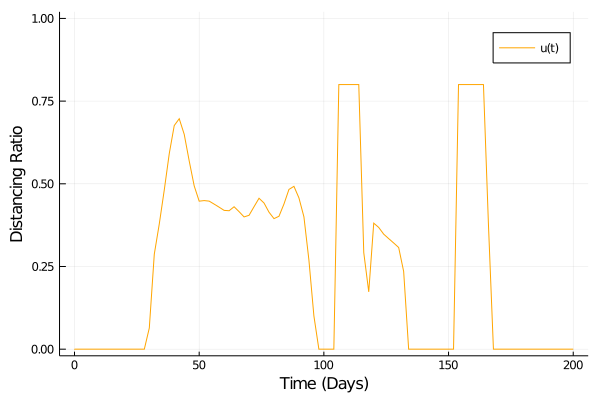

In [52]:
# Plot the values of u(t) over time
plot(ts, u_opt, linecolor = :orange, label = "u(t)", ylims = (-0.02, 1.02))
xlabel!("Time (Days)")
ylabel!("Distancing Ratio")